# Step 2: Exploratory Data Analysis (EDA)

This notebook performs a comprehensive analysis of the Art Style dataset to understand class distribution, image dimensions, color profiles, and brightness levels. These insights are crucial for designing an effective preprocessing pipeline in Phase 2.

In [1]:
# --- Setup & Configuration ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

# Configure plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Define paths
METADATA_PATH = '../data/processed/metadata.csv'
FIGURES_DIR = '../results/figures'

# Create output directory if it doesn't exist
os.makedirs(FIGURES_DIR, exist_ok=True)

print("Setup complete. Figures will be saved to:", FIGURES_DIR)

Setup complete. Figures will be saved to: ../results/figures


### 1. Load Data
We load the metadata CSV generated in Step 1 to access image paths and labels.

In [2]:
if not os.path.exists(METADATA_PATH):
    raise FileNotFoundError(f"Metadata file not found at {METADATA_PATH}. Please run Step 1 (data_curation.py) first.")

df = pd.read_csv(METADATA_PATH)

print(f"Dataset Loaded Successfully.")
print(f"Total Images: {len(df)}")
print(f"Total Styles: {df['style'].nunique()}")
print("-" * 30)
print("Top 5 styles by count:")
print(df['style'].value_counts().head())

Dataset Loaded Successfully.
Total Images: 22666
Total Styles: 27
------------------------------
Top 5 styles by count:
style
Abstract_Expressionism    1000
Impressionism             1000
Symbolism                 1000
Romanticism               1000
Rococo                    1000
Name: count, dtype: int64


### 2. Class Distribution Analysis
Visualizing the number of images per style to check for dataset balance.

C:\Users\AM\AppData\Local\Temp\ipykernel_8896\1151174227.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='style', order=df['style'].value_counts().index, palette='viridis')


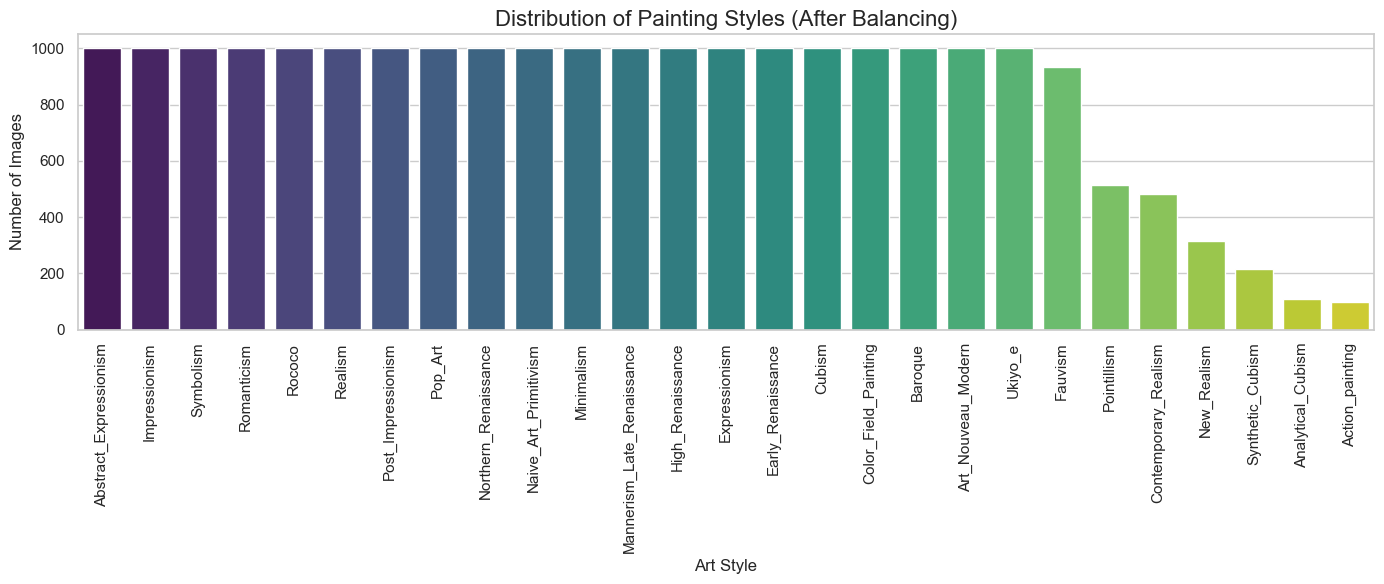

In [3]:
plt.figure(figsize=(14, 6))
# Plot count of images per style
sns.countplot(data=df, x='style', order=df['style'].value_counts().index, palette='viridis')

plt.title('Distribution of Painting Styles (After Balancing)', fontsize=16)
plt.xlabel('Art Style', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

# Save and Show
plt.savefig(os.path.join(FIGURES_DIR, '1_class_distribution.png'))
plt.show()

#### Analysis 1: Class Distribution
The bar chart illustrates the distribution of images across different art styles after the data curation process.
* **Observation:** The dataset is significantly more balanced compared to the raw data. The target was set to **1,000 images per class**. Most major styles (e.g., Impressionism, Realism) reached this cap, while some minority styles may have fewer samples due to raw data limitations.
* **Implication:** For training (Phase 2), we will employ **Weighted Random Sampling** or **Data Augmentation** techniques to handle any remaining minor imbalances and prevent model bias towards majority classes.

### 3. Visual Inspection (Sample Grid)
Displaying random samples to understand the visual diversity and complexity of the dataset.

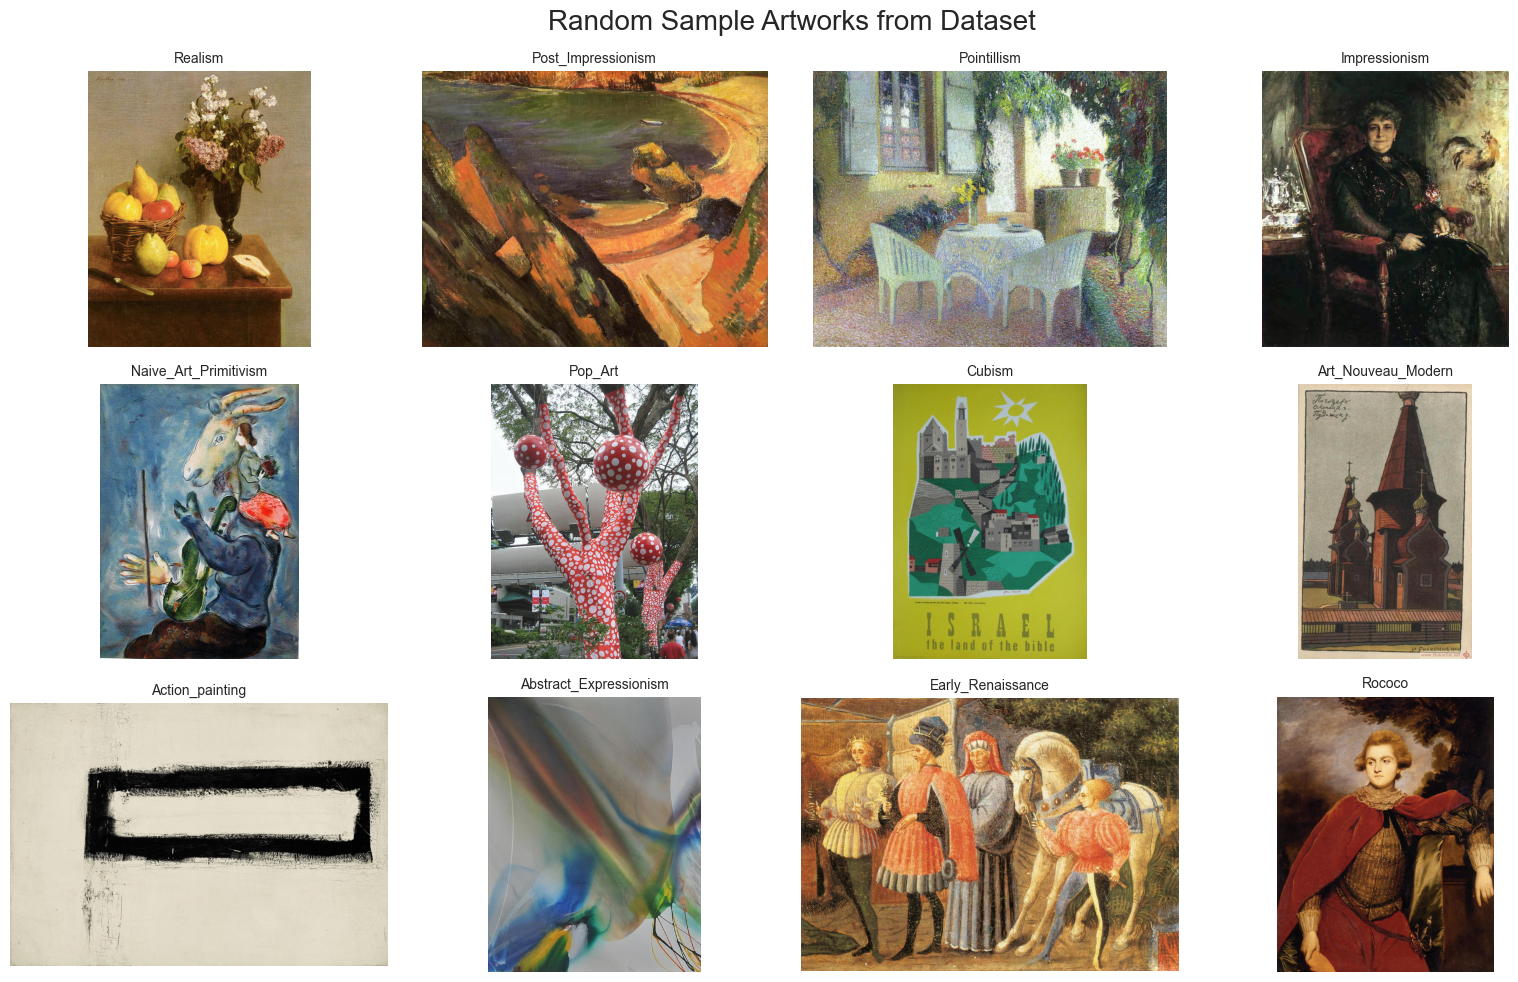

In [4]:
def show_sample_grid(df, n_rows=3, n_cols=4):
    plt.figure(figsize=(16, 10))
    # Select random styles
    unique_styles = df['style'].unique()
    selected_styles = np.random.choice(unique_styles, size=n_rows*n_cols, replace=False)
    
    for i, style in enumerate(selected_styles):
        # Get a random image for this style
        sample_row = df[df['style'] == style].sample(1).iloc[0]
        img_path = os.path.join('..', sample_row['image_path'])
        
        try:
            img = Image.open(img_path)
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(img)
            plt.title(style, fontsize=10)
            plt.axis('off')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            
    plt.suptitle('Random Sample Artworks from Dataset', fontsize=20)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, '2_sample_grid.png'))
    plt.show()

show_sample_grid(df)

#### Analysis 2: Visual Inspection
The grid displays random samples from various art styles.
* **Observation:** There is a high inter-class variance. For example, 'Cubism' features geometric shapes, while 'Baroque' focuses on realistic lighting and figures. The images also vary in aspect ratio and texture.
* **Implication:** The model needs to learn complex features (texture, shapes, and colors). Simple edge detection will not be sufficient; a deep CNN (like ResNet) is required to capture these high-level artistic abstractions.

### 4. Feature Extraction
Extracting physical properties (Width, Height, Brightness) from a subset of images for statistical analysis.

In [5]:
# We sample 2000 images to speed up the analysis loop
sample_df = df.sample(n=min(2000, len(df)), random_state=42).copy()

widths = []
heights = []
brightness_vals = []

print("Extracting features from sample images... (This may take a moment)")

for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    path = os.path.join('..', row['image_path'])
    try:
        # Get Dimensions
        with Image.open(path) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)
            
            # Get Brightness (Convert to Greyscale)
            gray_img = img.convert('L')
            stat = np.array(gray_img)
            brightness_vals.append(stat.mean())
            
    except Exception as e:
        widths.append(np.nan)
        heights.append(np.nan)
        brightness_vals.append(np.nan)

# Add features to DataFrame
sample_df['Width'] = widths
sample_df['Height'] = heights
sample_df['Brightness'] = brightness_vals

# Drop errors
sample_df = sample_df.dropna()
print("Feature extraction complete.")

Extracting features from sample images... (This may take a moment)


100%|██████████| 2000/2000 [01:44<00:00, 19.22it/s]

Feature extraction complete.


### 5. Image Dimensions Analysis
Checking image sizes to determine the resizing strategy.

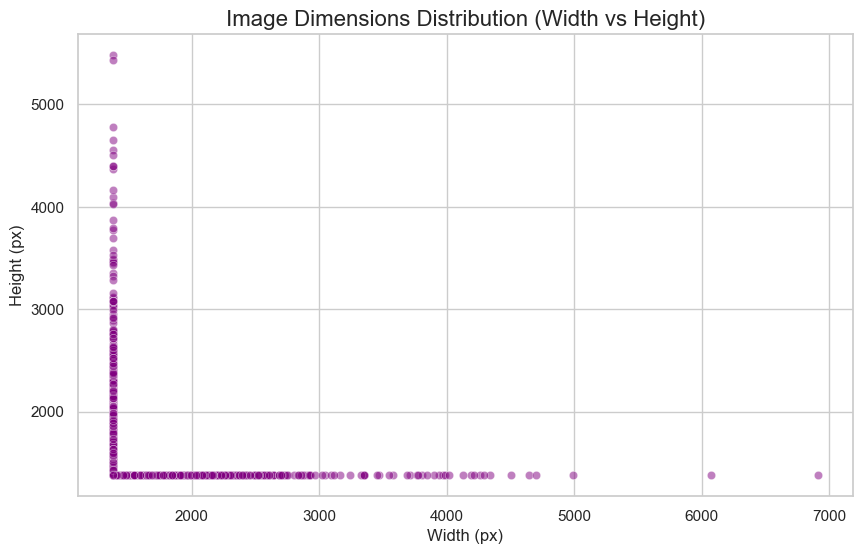

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_df, x='Width', y='Height', alpha=0.5, color='purple')
plt.title('Image Dimensions Distribution (Width vs Height)', fontsize=16)
plt.xlabel('Width (px)')
plt.ylabel('Height (px)')
plt.savefig(os.path.join(FIGURES_DIR, '3_dimensions_scatter.png'))
plt.show()

#### Analysis 3: Image Dimensions
This scatter plot shows the relationship between the width and height of the images.
* **Observation:** The L-shape pattern indicates a mix of Portrait (tall) and Landscape (wide) orientations. Sizes vary drastically, from small (~500px) to very large (>3000px).
* **Implication:** Direct resizing to a square (e.g., 224x224) would distort the aspect ratio of the artwork. In the preprocessing pipeline, we must use **RandomResizedCrop** or **Resize with Padding** to maintain the artistic integrity of the images before feeding them into the neural network.

### 6. Color Analysis
Analyzing the RGB histogram of a representative image.

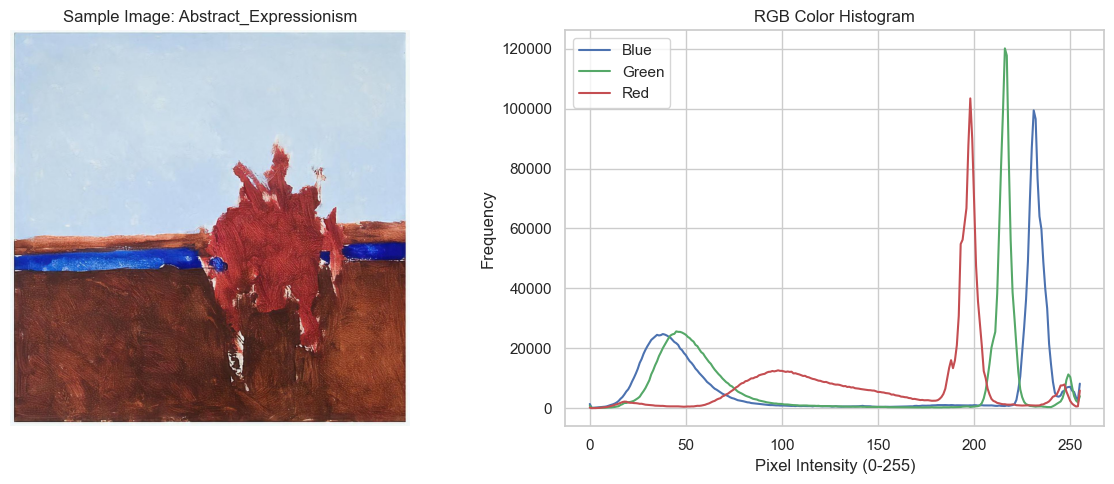

In [7]:
# Analyze color distribution for a specific style (most common one)
target_style = df['style'].value_counts().idxmax()
sample_row = df[df['style'] == target_style].sample(1).iloc[0]
img_path = os.path.join('..', sample_row['image_path'])

img_cv = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 5))

# Subplot 1: The Image
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title(f'Sample Image: {sample_row["style"]}')
plt.axis('off')

# Subplot 2: The Histogram
plt.subplot(1, 2, 2)
colors = ('b', 'g', 'r')
labels = ('Blue', 'Green', 'Red')
for i, col in enumerate(colors):
    # Calculate Histogram for each channel
    hist = cv2.calcHist([img_cv], [i], None, [256], [0, 256])
    plt.plot(hist, color=col, label=labels[i])

plt.title('RGB Color Histogram')
plt.xlabel('Pixel Intensity (0-255)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, '4_color_histogram.png'))
plt.show()

#### Analysis 4: Color Analysis
The histogram displays the pixel intensity distribution for Red, Green, and Blue channels of a sample image.
* **Observation:** Different styles exhibit distinct color signatures. For example, Impressionism often uses vibrant, high-intensity ranges, while Renaissance might focus on darker, mid-range tones.
* **Implication:** Since color is a primary feature of art style, we should consider using color-based augmentations (like **ColorJitter**) carefully. We want the model to learn the *composition* of color, not just memorize specific color palettes.

### 7. Brightness Distribution
Checking the global lighting conditions of the dataset.

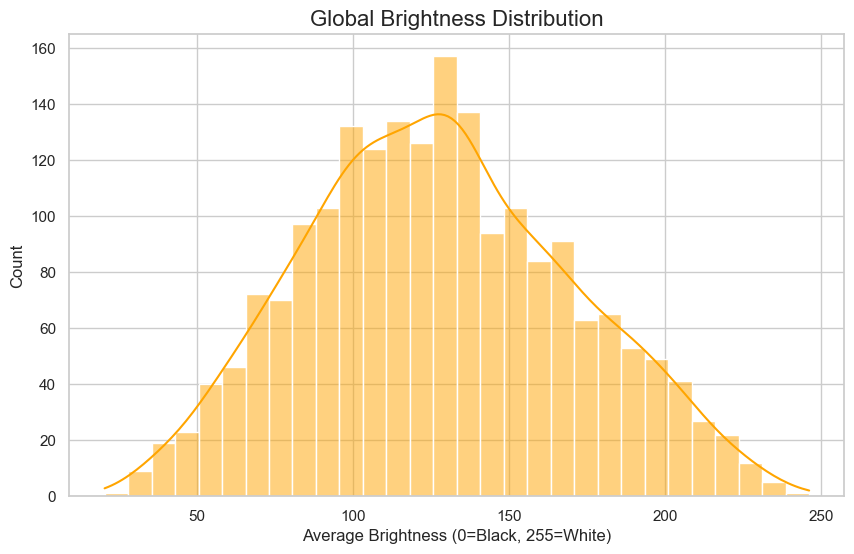

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(sample_df['Brightness'], kde=True, color='orange', bins=30)
plt.title('Global Brightness Distribution', fontsize=16)
plt.xlabel('Average Brightness (0=Black, 255=White)')
plt.savefig(os.path.join(FIGURES_DIR, '5_brightness_dist.png'))
plt.show()

#### Analysis 5: Brightness Distribution
This histogram shows the average brightness of images across the dataset.
* **Observation:** The distribution follows a near-normal (Gaussian) curve centered around 110-130. This indicates a healthy dynamic range without extreme bias towards overexposed (too bright) or underexposed (too dark) images.
* **Implication:** Standard **Normalization** using ImageNet means `[0.485, 0.456, 0.406]` and stds `[0.229, 0.224, 0.225]` will work effectively to scale these pixel values for the neural network.

### 8. Feature Correlation Matrix
Checking for relationships between physical attributes of images.

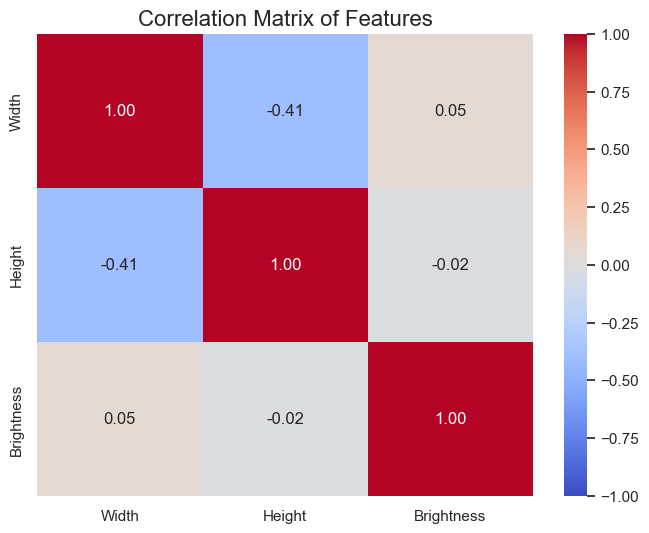

In [9]:
plt.figure(figsize=(8, 6))
# Calculate correlation between physical features
corr_matrix = sample_df[['Width', 'Height', 'Brightness']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features', fontsize=16)
plt.savefig(os.path.join(FIGURES_DIR, '6_correlation_matrix.png'))
plt.show()

#### Analysis 6: Feature Correlation
The heatmap displays the Pearson correlation coefficients between image features.
* **Observation:** There is a notable negative correlation between Width and Height. This confirms that images tend to be either wide (Landscape) or tall (Portrait), rarely both (square). Brightness shows almost zero correlation with dimensions.
* **Implication:** The "Style" of an artwork is independent of its canvas size. The preprocessing pipeline must handle varying aspect ratios robustly to prevent model confusion.